In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from itertools import cycle
import joblib

# Set plot style
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)

# For reproducibility
np.random.seed(42)

In [2]:
# Load the project dataset
from prep import preprocess_data

train_df = pd.read_csv('./apache/train_labeled.csv')
test_df = pd.read_csv('./apache/test_labeled.csv')

train_df = preprocess_data(train_df, compact=True)
test_df = preprocess_data(test_df, compact=True)

# check if the columns are the same
if set(train_df.columns) != set(test_df.columns):
    print("Warning: Train and test datasets have different columns.")
    # Print the differences
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    # get the columns that are in train but not in test
    train_only = train_columns - test_columns
    # get the columns that are in test but not in train
    test_only = test_columns - train_columns
    if train_only:
        print(f"Columns in train but not in test: {train_only}")
    if test_only:
        print(f"Columns in test but not in train: {test_only}")

In [3]:
# Ensure that project_category in both datasets has the same categories
if not train_df['project_category'].equals(test_df['project_category']):
    print("Warning: project_category in train and test datasets do not match.")
    
    train_categories = set(train_df['project_category'].unique())
    test_categories = set(test_df['project_category'].unique())

    # Print the differences
    train_only = train_categories - test_categories
    test_only = test_categories - train_categories
    if train_only:
        print(f"Categories in train but not in test: {train_only}")
    if test_only:
        print(f"Categories in test but not in train: {test_only}")

Categories in train but not in test: {'Geospatial'}


In [4]:
# Encode 'project_category' using data from train_df
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = oe.fit_transform(train_df[['project_category']])
test_encoded = oe.transform(test_df[['project_category']])
# Create DataFrames for the encoded categories
train_encoded_df = pd.DataFrame(train_encoded, columns=oe.get_feature_names_out(['project_category']))
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
# Concatenate the encoded DataFrames with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [5]:
# useful columns derived from feature engineering
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# Filter the DataFrame to keep only the top predictors (plus 'project_category' and the target variable)
schedule_train_df = train_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_train_df = train_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

schedule_test_df = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_test_df = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

In [6]:
target = 'schedule_risk'
# target = 'quality_risk'

if target == 'schedule_risk':
    train_df = schedule_train_df
    test_df = schedule_test_df
    features = schedule_features
elif target == 'quality_risk':
    train_df = quality_train_df
    test_df = quality_test_df
    features = quality_features

In [7]:
# Prepare data for modeling
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled feature values:")
print(f"Mean of scaled training data: {np.mean(X_train_scaled, axis=0)}")
print(f"Standard deviation of scaled training data: {np.std(X_train_scaled, axis=0)}")


Scaled feature values:
Mean of scaled training data: [ 1.01093479e-16 -7.22096276e-18  0.00000000e+00 -1.80524069e-17
  9.02620345e-18  7.22096276e-18  1.44419255e-17  7.22096276e-18
 -5.41572207e-17  2.88838510e-17  3.61048138e-17  7.85279700e-17
 -2.52733697e-17  6.85991462e-17 -2.20239364e-16 -5.77677021e-17
  9.38725159e-17  3.61048138e-17 -1.80524069e-17 -1.44419255e-17
 -5.41572207e-18  2.52733697e-17 -1.08314441e-17 -2.16628883e-17
 -1.44419255e-17  3.61048138e-18  9.02620345e-18  6.13781835e-17
 -6.13781835e-17 -5.32546004e-17 -7.22096276e-18 -1.80524069e-17]
Standard deviation of scaled training data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Baseline Model Accuracy: 0.9194

Classification Report for Baseline Model:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95        93
           1       0.80      0.90      0.85        31

    accuracy                           0.92       124
   macro avg       0.88      0.91      0.90       124
weighted avg       0.92      0.92      0.92       124



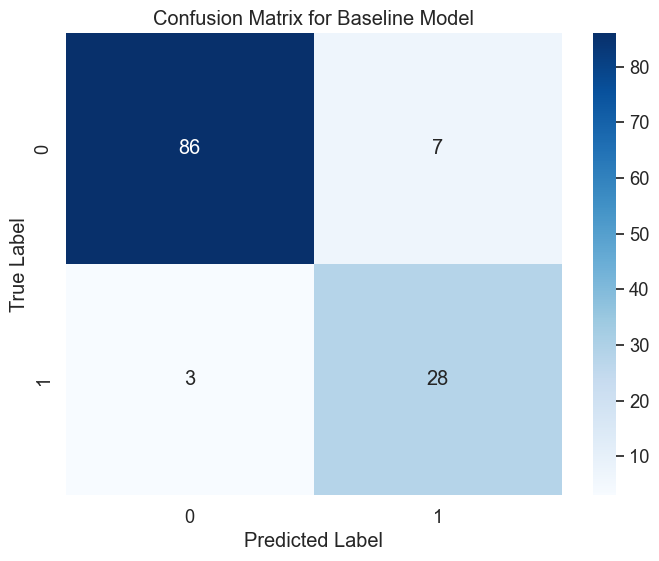

In [8]:
# Create a baseline logistic regression model
baseline_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Fit the model
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_test_scaled)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# Classification report
print("\nClassification Report for Baseline Model:")
print(classification_report(y_test, y_pred_baseline))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Baseline Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
# Perform k-fold cross-validation on the baseline model
n_folds = 5
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=n_folds, scoring='accuracy')
print(f"\nCross-validation scores (k={n_folds}): {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-validation scores (k=5): [0.94949495 0.87878788 0.89795918 0.87755102 0.91836735]
Mean cross-validation accuracy: 0.9044 ± 0.0270


In [10]:
# Hyperparameter tuning using GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'elasticnet'],
    'solver': ['saga'],  # 'saga' supports elasticnet penalty
    'l1_ratio': [0.0, 0.1, 0.5, 0.7, 0.9, 1.0]  # l1_ratio required for elasticnet, ignored for l2
}

# Creata a logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Perform GridSearchCV
print("\nStarting hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(lr_model, param_grid, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_


Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best parameters: {'C': 0.1, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation score: 0.9228



Best Model Accuracy: 0.9435
Improvement over baseline: 0.0242

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        93
           1       0.88      0.90      0.89        31

    accuracy                           0.94       124
   macro avg       0.92      0.93      0.93       124
weighted avg       0.94      0.94      0.94       124



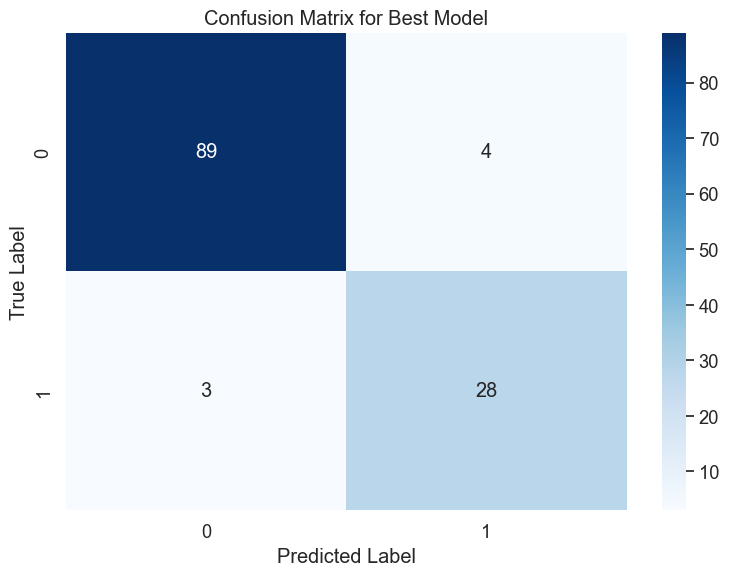

In [11]:
# Make predictions with the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Model Accuracy: {accuracy:.4f}")

# Calculate if there was an improvement over the baseline
improvement = accuracy - baseline_accuracy
print(f"Improvement over baseline: {improvement:.4f}")

# Classification report for the best model
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred))

# Confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

In [12]:
# Get probability predictions
y_prob = best_model.predict_proba(X_test_scaled)

# Display probabilities for the first 10 predictions
print("\nPredicted probabilities for the first 10 samples:")
prob_df = pd.DataFrame(y_prob, columns=best_model.classes_)
prob_df['True Label'] = y_test.values
prob_df['Predicted Label'] = y_pred
print(prob_df.head(10))


Predicted probabilities for the first 10 samples:
          0         1  True Label  Predicted Label
0  0.943065  0.056935           0                0
1  0.441213  0.558787           0                1
2  0.962318  0.037682           0                0
3  0.458445  0.541555           1                1
4  0.540870  0.459130           0                0
5  0.951944  0.048056           0                0
6  0.005768  0.994232           1                1
7  0.682900  0.317100           0                0
8  0.847676  0.152324           0                0
9  0.831700  0.168300           0                0


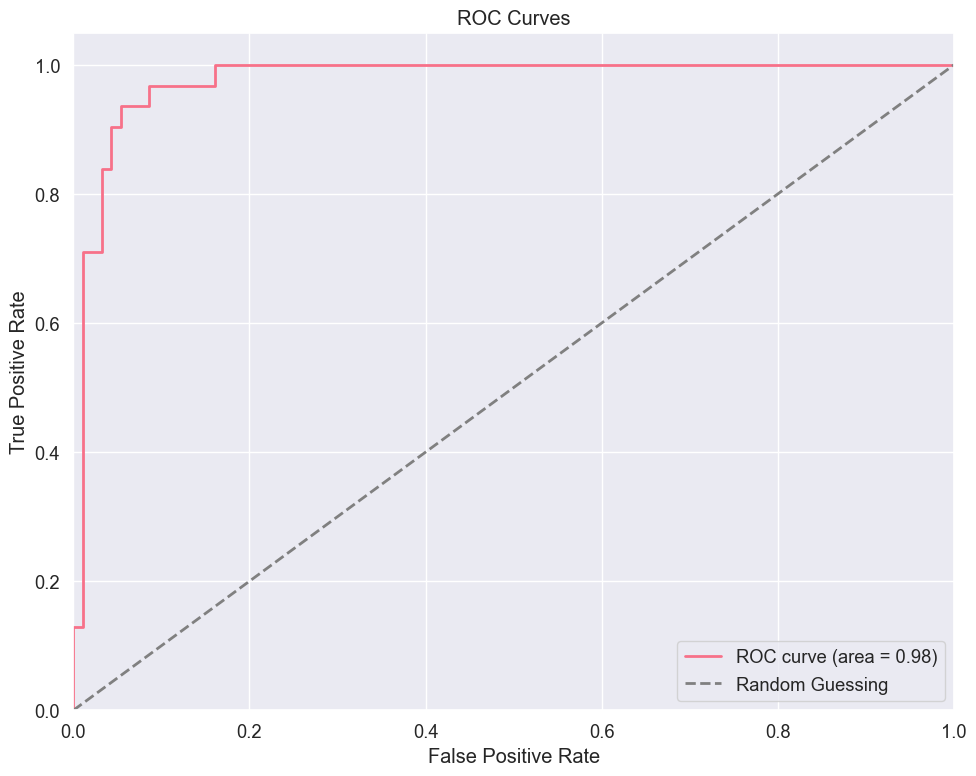

In [13]:
# ROC curve and AUC analysis

fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", 2)  # Use seaborn's color palette

plt.plot(fpr, tpr, color=colors[0], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guessing')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

Top 10 most influential features:
                                              Feature  Coefficient  \
0                            num_resolution_fixed_pct    -2.278117   
14                                   resolution_ratio     1.193567   
3                        num_resolution_won't_fix_pct    -1.147560   
11                                   average_lifespan    -0.168338   
9                              average_change_density    -0.138089   
16  project_category_Build, Release, & Project Man...    -0.130727   
10                         average_status_change_rate    -0.125617   
12                                      total_members    -0.114769   
6                                     total_reporters    -0.110393   
5                                        total_issues    -0.101449   

    Absolute_Coefficient  
0               2.278117  
14              1.193567  
3               1.147560  
11              0.168338  
9               0.138089  
16              0.130727  
10    

C:\Users\phuon\AppData\Local\Temp\ipykernel_9376\1607234222.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted, palette=colors)


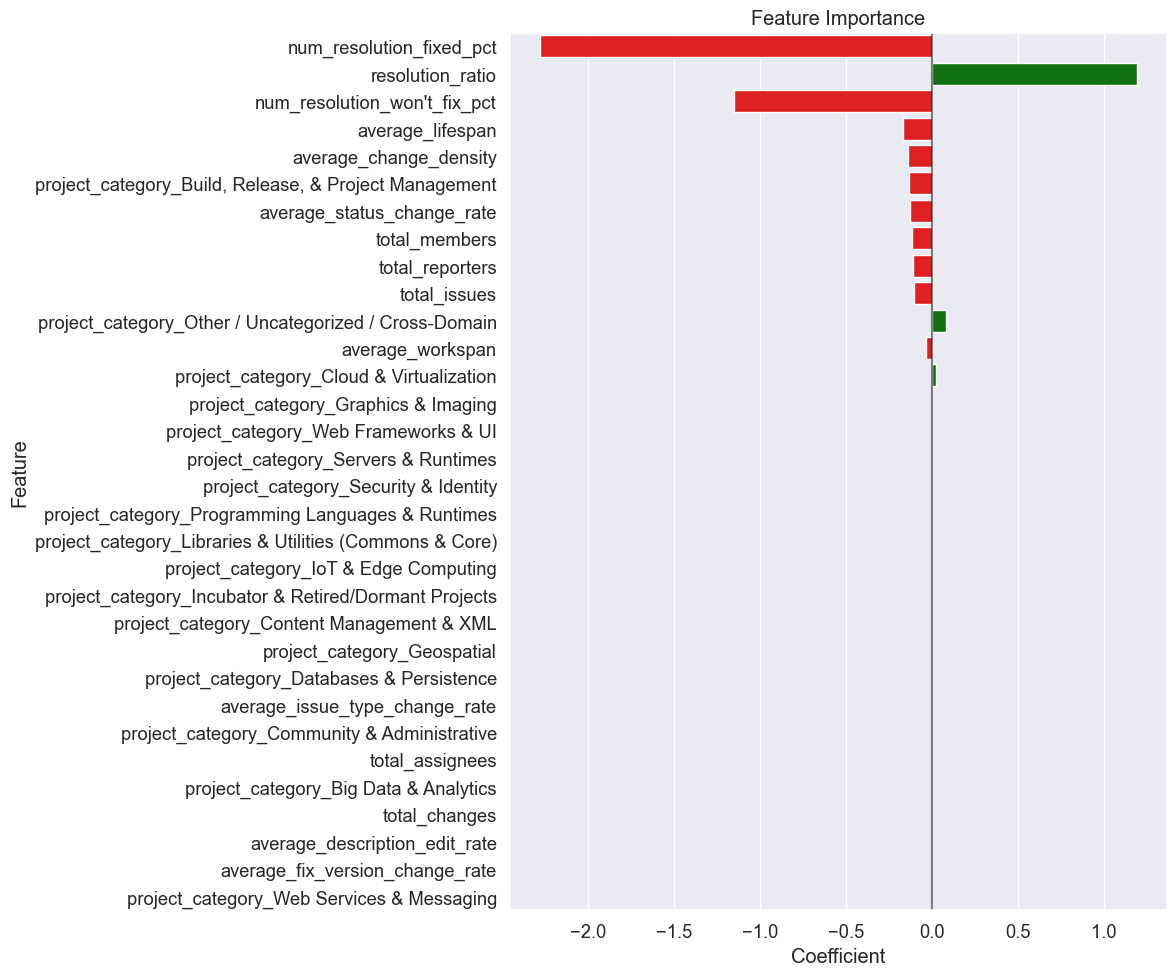


Out of 15 known top schedule_risk predictors:
10 appear among the top 15 features by coefficient magnitude.
Common features: {'average_status_change_rate', 'total_members', 'average_change_density', 'total_reporters', 'average_lifespan', 'resolution_ratio', 'num_resolution_fixed_pct', "num_resolution_won't_fix_pct", 'total_issues', 'average_workspan'}


In [14]:
# Coefficient analysis
feature_names = X_train.columns

# Get the coefficients from the best model
coefs = best_model.coef_[0]  # For binary classification, there's only one set of coefficients
intercept = best_model.intercept_[0]

# Create a DataFrame to show feature importance
coef_df = pd.DataFrame({
	'Feature': feature_names,
	'Coefficient': coefs,
})

# Sort by absolute coefficient value to see most influential features
coef_df['Absolute_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values('Absolute_Coefficient', ascending=False)

print("Top 10 most influential features:")
print(coef_df_sorted.head(10))

print(f"\nIntercept: {intercept:.4f}")

# Visualize the coefficients
plt.figure(figsize=(12, 10))
colors = ['red' if c < 0 else 'green' for c in coef_df_sorted['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted, palette=colors)
plt.title('Feature Importance')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

# Compare with known top predictors
top_features = set(features)
top_coefficients = set(coef_df_sorted.head(len(features))['Feature'])
common_features = top_features.intersection(top_coefficients)

print(f"\nOut of {len(features)} known top {target} predictors:")
print(f"{len(common_features)} appear among the top {len(features)} features by coefficient magnitude.")
print(f"Common features: {common_features}")


Explained variance by PCA components: [0.14437931 0.07979244]
PC1 explains 14.44% of the variance.
PC2 explains 7.98% of the variance.


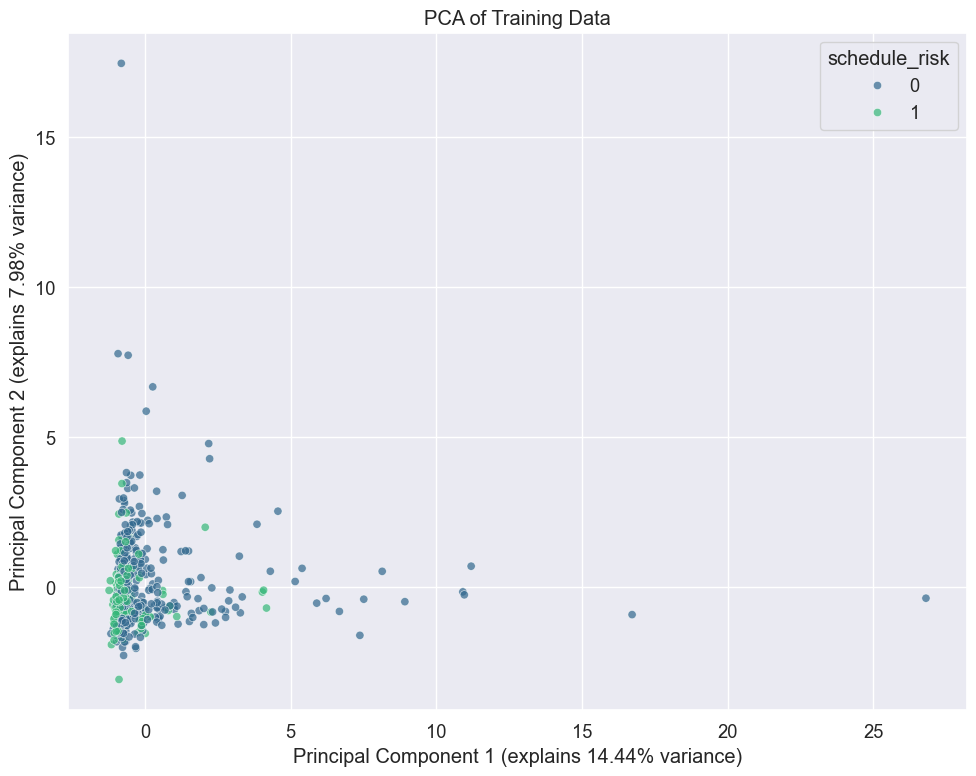

In [15]:
# Dimension reduction for visualization

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
print(f"\nExplained variance by PCA components: {explained_variance}")
print(f"PC1 explains {explained_variance[0] * 100:.2f}% of the variance.")
print(f"PC2 explains {explained_variance[1] * 100:.2f}% of the variance.")

# Visualize the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('PCA of Training Data')
plt.xlabel(f'Principal Component 1 (explains {explained_variance[0] * 100:.2f}% variance)')
plt.ylabel(f'Principal Component 2 (explains {explained_variance[1] * 100:.2f}% variance)')
plt.legend(title=target, loc='upper right')
plt.grid(True)
plt.tight_layout()

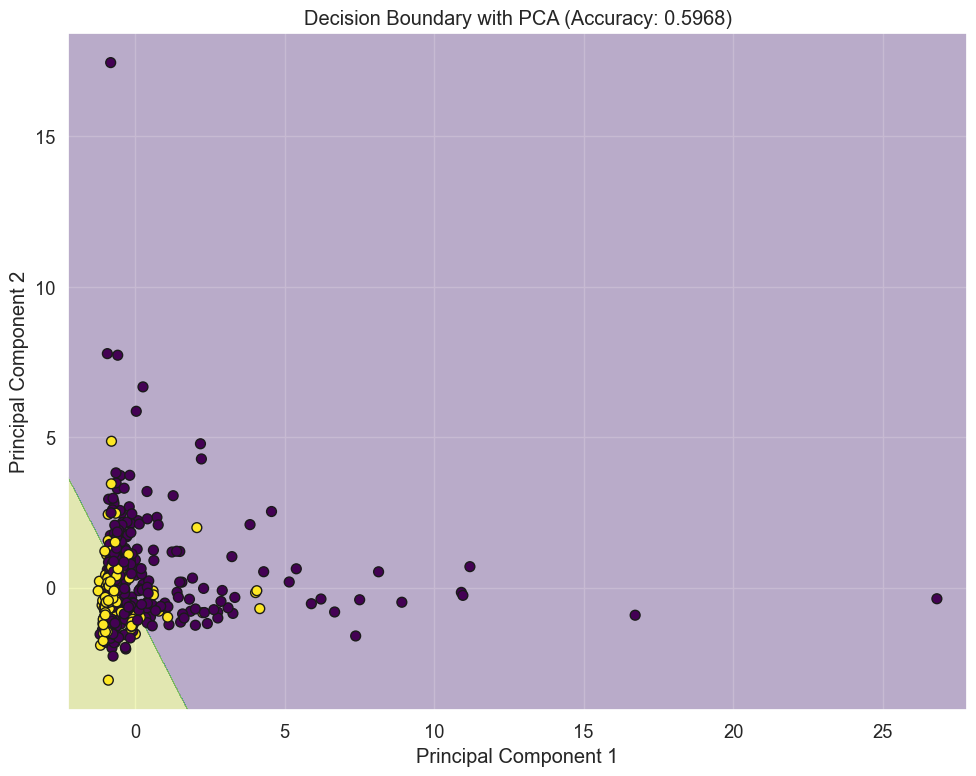

In [16]:
# Decision boundary visualization

def plot_decision_boundary(model, X, y):
    # Set min and max values for the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap='viridis')
    plt.title('Decision Boundary of the Model')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.tight_layout()

# Create a model using the best parameters found
lr_pca = LogisticRegression(**best_model.get_params())
lr_pca.fit(X_train_pca, y_train)

# Calculate accuracy on PCA-transformed data
test_pca_accuracy = accuracy_score(y_test, lr_pca.predict(X_test_pca))

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plot_decision_boundary(lr_pca, X_train_pca, y_train)
plt.title(f'Decision Boundary with PCA (Accuracy: {test_pca_accuracy:.4f})')
plt.show()

In [17]:
# 16. Model Persistence

# Create directory for models if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = f'models/{target}_logistic_regression_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nModel saved to {model_filename}")

# Also save the scaler for future preprocessing
scaler_filename = f'models/{target}_logistic_regression_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

# Example of how to load the model and scaler
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Test the loaded model
new_data = X_test  # Using test data as an example
new_data_scaled = loaded_scaler.transform(new_data)
predictions = loaded_model.predict(new_data_scaled)

print(f"Loaded model accuracy on test set: {accuracy_score(y_test, predictions):.4f}")


Model saved to models/schedule_risk_logistic_regression_model.joblib
Scaler saved to models/schedule_risk_logistic_regression_scaler.joblib
Loaded model accuracy on test set: 0.9435


## Model Explainability with SHAP

In [18]:
target_names = ['Low Risk', 'High Risk']

In [19]:
# 18. Model Explainability with SHAP (SHapley Additive exPlanations)

# First, we need to install SHAP if it's not already installed
try:
    import shap
except ImportError:
    %pip install shap
    import shap

print("SHAP Analysis for Logistic Regression Model")
print("==========================================")

# Create a SHAP explainer for the logistic regression model
# For logistic regression, we can use the LinearExplainer
explainer = shap.LinearExplainer(
    best_model,
    shap.maskers.Independent(X_train_scaled)
)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Initialize JavaScript visualization
shap.initjs()

# Save the masker for future use
masker_filename = f'models/{target}_logistic_regression_masker.joblib'
joblib.dump(explainer.masker, masker_filename)
print(f"Masker saved to {masker_filename}")

SHAP Analysis for Logistic Regression Model


Masker saved to models/schedule_risk_logistic_regression_masker.joblib


In [20]:
# Set a custom threshold for visibility
shap_threshold = 0.05

In [21]:
shap_threshold = 0.05  # Set a threshold for significant SHAP values
significant_features = np.abs(shap_values).mean(axis=0) > shap_threshold

C:\Users\phuon\AppData\Local\Temp\ipykernel_9376\1308588068.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(filtered_shap_values, filtered_X_test, feature_names=filtered_feature_names, class_names=target_names, plot_type='bar')


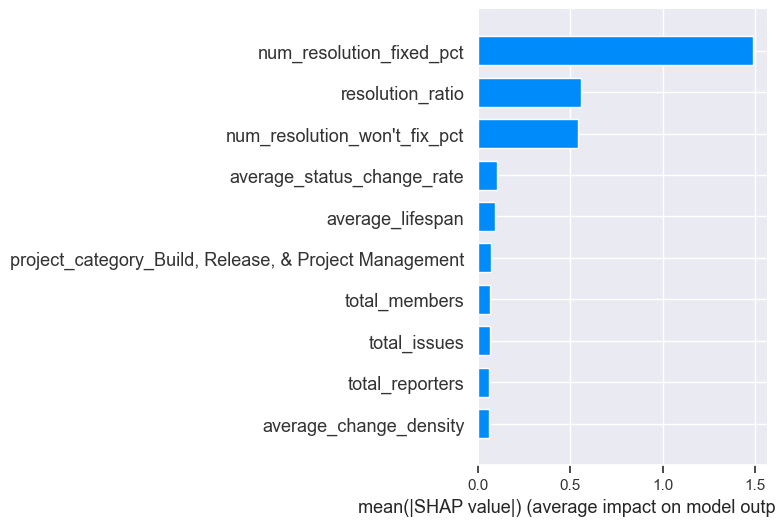

C:\Users\phuon\AppData\Local\Temp\ipykernel_9376\1308588068.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(filtered_shap_values, filtered_X_test, feature_names=filtered_feature_names, class_names=target_names)


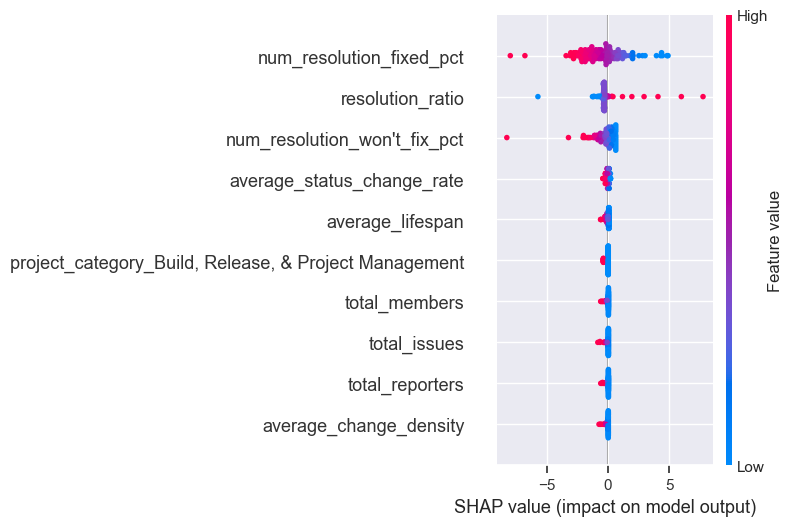

In [22]:
# Filter features by SHAP threshold
filtered_indices = np.where(significant_features)[0]
filtered_shap_values = shap_values[:, filtered_indices]
filtered_X_test = X_test_scaled[:, filtered_indices]
filtered_feature_names = X_train.columns[filtered_indices]

# For binary classification, visualize the SHAP values for the positive class (filtered)
shap.summary_plot(filtered_shap_values, filtered_X_test, feature_names=filtered_feature_names, class_names=target_names, plot_type='bar')
# Beeswarm plot (filtered)
shap.summary_plot(filtered_shap_values, filtered_X_test, feature_names=filtered_feature_names, class_names=target_names)

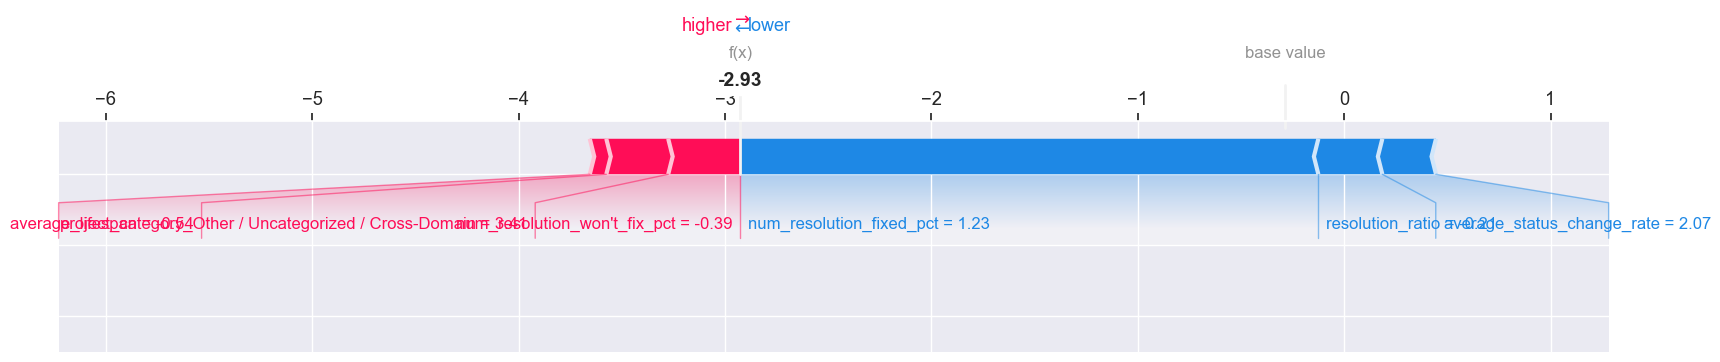

In [23]:
# Force plot for the first instance in the test set, only showing features with abs SHAP > threshold
instance_idx = 0
shap_vals_instance = shap_values[instance_idx]
instance_features = X_test_scaled[instance_idx]
feature_names = X_train.columns

# Mask for significant features
mask = np.abs(shap_vals_instance) > shap_threshold

# Filter values and names
filtered_shap_vals = shap_vals_instance[mask]
filtered_instance_features = instance_features[mask]
filtered_feature_names = feature_names[mask]

# Round SHAP values and feature values to 2 decimal places for display
shap.force_plot(
	explainer.expected_value,
	np.round(filtered_shap_vals, 2),
	np.round(filtered_instance_features, 2),
	feature_names=filtered_feature_names,
	matplotlib=True
)

Base value (log-odds): -0.285 => Probability: 0.429
f(x) (log-odds): -2.807 => Probability: 0.057


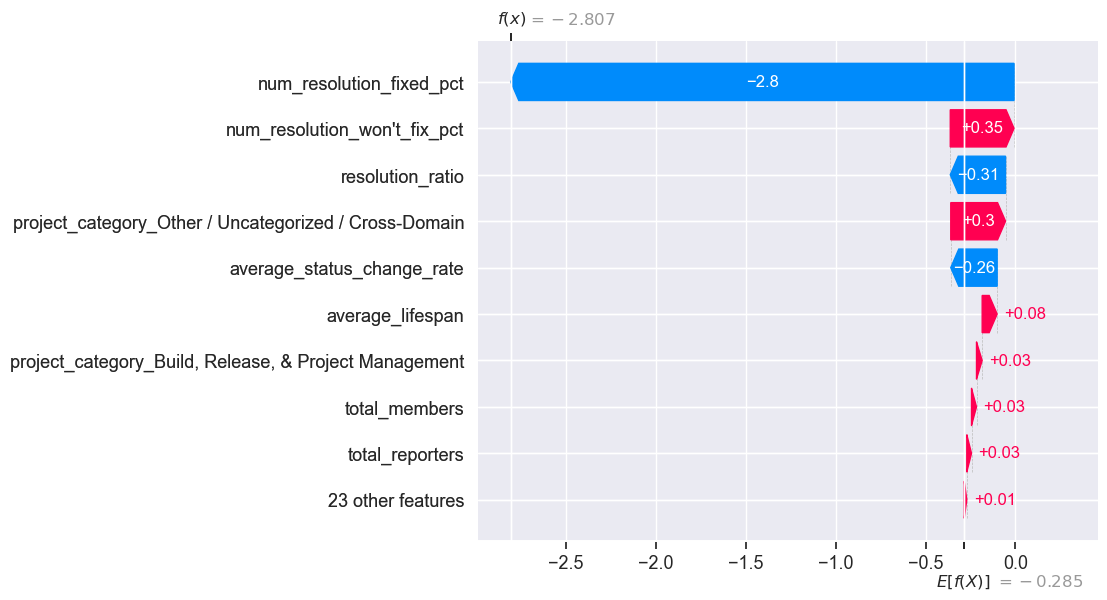

In [24]:
# Waterfall plot for the first instance, showing probabilities instead of log-odds
import scipy.special

def logit_to_prob(logit):
    return scipy.special.expit(logit)

# Convert SHAP values and base value to probability space
logit_base = explainer.expected_value
logit_sum = logit_base + shap_vals_instance.sum()
prob_base = logit_to_prob(logit_base)
prob_sum = logit_to_prob(logit_sum)

print(f"Base value (log-odds): {logit_base:.3f} => Probability: {prob_base:.3f}")
print(f"f(x) (log-odds): {logit_sum:.3f} => Probability: {prob_sum:.3f}")

# For visualization, you can show the original waterfall plot, but annotate with probabilities
shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals_instance,
        base_values=explainer.expected_value,
        data=None,
        feature_names=feature_names
    ),
    max_display=10,
    show=True
)
# plt.title(f"SHAP Waterfall Plot (log-odds)\nBase prob: {prob_base:.3f}, f(x) prob: {prob_sum:.3f}")
# plt.show()

# If you want a true probability-space waterfall, you would need to re-calculate SHAP values in probability space, which is not directly supported by SHAP. The above approach is the standard and recommended way to interpret the results.